# Initial thoughts

My initial question is that the number of references in a paper has been increasing in time from my experience. Additionally, considering this, the number of papers with large citations, which we should define properly, should increase since good papers tend to be cited continuously. It will be interesting to see if the ratio of these outlier papers increases.

# Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/data_nucl-th_100_preprocessed.csv")

In [3]:
df.shape

(3096, 15)

The shape of the data is (3096, 15), while there are some metadata which cannot be used for machine learning. Such columns are `publication_info`, `authors`, `references`, and `arxiv_eprints`. We left these columns for future reference. Therefore, technically the relevant shape is (3096, 11).

In [4]:
columns_metadata = ['publication_info', 'authors', 'references', 'arxiv_eprints']

df = df.drop(columns=columns_metadata)

print(df.shape)

df.head()

(3096, 11)


,id,citation_count_without_self_citations,citation_count,citeable,number_of_pages,preprint_date,author_count,refereed,document_type,publication_type,number_of_references
0,1459726,10,20,True,20.0,1995-03-28,3,True,article,research,41
1,1459842,4,4,True,5.0,1995-04-07,2,True,article,research,19
2,1460442,47,51,True,6.0,1995-01-17,2,True,article,research,17
3,392718,1,1,True,12.0,1995-01,2,False,conference paper,research,16
4,397533,65,67,True,4.0,1995-07,2,True,article,research,17


Each row represents a data from a paper.

Columns are `id`, `citation_without_self_citations`, `citation_count`, `citable`, `number_of_pages`, `preprint_date`, `author_count`, `referred`, `document_type`, `publicaiton_type`, `number_of_references`. Here, self-citation are references made by researchers belonging to the same collaboration or by any of the authors of the paper being cited

In [5]:
df[df.duplicated(keep=False)]

,id,citation_count_without_self_citations,citation_count,citeable,number_of_pages,preprint_date,author_count,refereed,document_type,publication_type,number_of_references


The above calculation shows that there is no duplicate since `.duplicated()` function gives duplicated rows with True or False. We checked it when we cleaned the data in pre-processing.

## Additional transformations/manipulations

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096 entries, 0 to 3095
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     3096 non-null   int64  
 1   citation_count_without_self_citations  3096 non-null   int64  
 2   citation_count                         3096 non-null   int64  
 3   citeable                               3096 non-null   bool   
 4   number_of_pages                        3096 non-null   float64
 5   preprint_date                          3096 non-null   object 
 6   author_count                           3096 non-null   int64  
 7   refereed                               3096 non-null   bool   
 8   document_type                          3096 non-null   object 
 9   publication_type                       3096 non-null   object 
 10  number_of_references                   3096 non-null   int64  
dtypes: b

Column `Preprint` should have `datetime` data type. Also, `document_type` and `publication_type` can be categorical. For `number_of_pages`, it has floats since we used mean imputation. We can test other imputations in the later section, such as replacing them with mode or median, so it will be left as what it is.

In [8]:
df['preprint_date'] = pd.to_datetime(df['preprint_date'], format='mixed', errors='coerce')
df['document_type'] = df['document_type'].astype('category')
df['publication_type'] = df['publication_type'].astype('category')

Since we used mixed format, it looks like the data without date are replaced with `YYYY-MM-01`. Because we are interested in the overall trend, we will not consider this seriously but we should note this for future refernce.

## Explore every variable

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096 entries, 0 to 3095
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   id                                     3096 non-null   int64         
 1   citation_count_without_self_citations  3096 non-null   int64         
 2   citation_count                         3096 non-null   int64         
 3   citeable                               3096 non-null   bool          
 4   number_of_pages                        3096 non-null   float64       
 5   preprint_date                          3096 non-null   datetime64[ns]
 6   author_count                           3096 non-null   int64         
 7   refereed                               3096 non-null   bool          
 8   document_type                          3096 non-null   category      
 9   publication_type                       3096 non-null   category

They don't have physical units. We can infer its units from the names of the columns and what they are.

Each variable represents:

`id`: It is the id for each paper. It is not relevant to study our claims, but it is relevant for checking duplicates. We will keep this column but not use this for machine learning.

`citation_count_without_self_citations`: It repesents the number of citations without self-citations.

`citation_count`: It represents the number of all citations.

`citeable`: It reprsents whether the paper is citeable. Since we checked that all papers here are citeable so we can remove this column.

`number_of_pages`: It represents the length of the paper.

`preprint_date`: It represents the date when the paper was first released on [arXiv](https://arxiv.org).

`author_count`: It reprsents the number of authors for a given paper. It might be relevant to `number_of_pages` and `number_of_references`.

`refereed`: It represents whether the paper was peer-reviewed. Conference proceedings are tend not to be referred in physics.

`document_type`: It represents the document type of the papers. It includes 'article', 'book chapter', 'conference paper', and 'thesis.

`publication_type`: It represents the publication type of the papers. It includes 'lectures`, 'research', and 'review'.

`number_of_references`: It represents the number of references in a given paper, which we will see its trend withi other variables.

In [10]:
df = df.drop(columns=['citeable'])

df.shape

(3096, 10)

The integer or float values are all positive. Since all numerical columns do not tend to change exponentially, or they cannot be normalized, we just keep the variables as previously.

Checking missing data using `df.isnull().sum()`

In [11]:
df.isnull().sum()

id                                       0
citation_count_without_self_citations    0
citation_count                           0
number_of_pages                          0
preprint_date                            0
author_count                             0
refereed                                 0
document_type                            0
publication_type                         0
number_of_references                     0
dtype: int64

Let us check outliers for numerical columns.

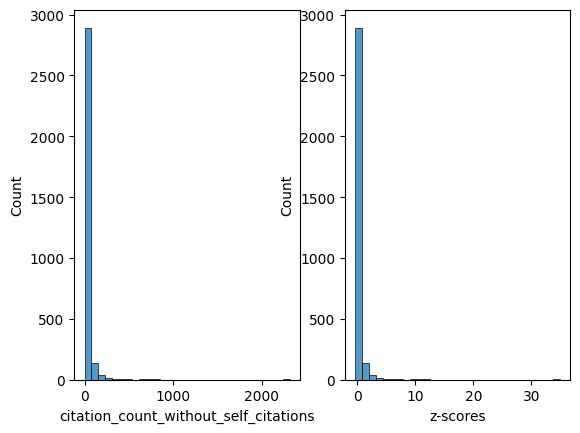

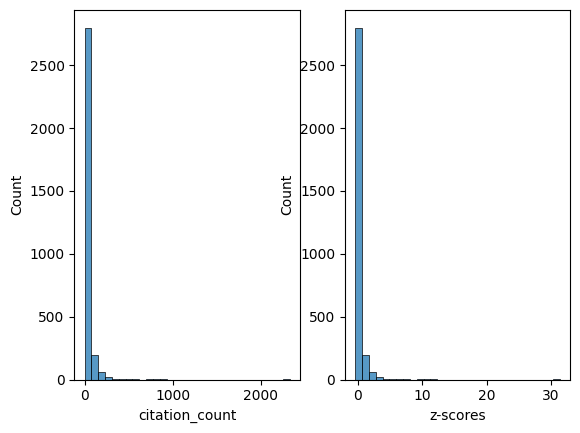

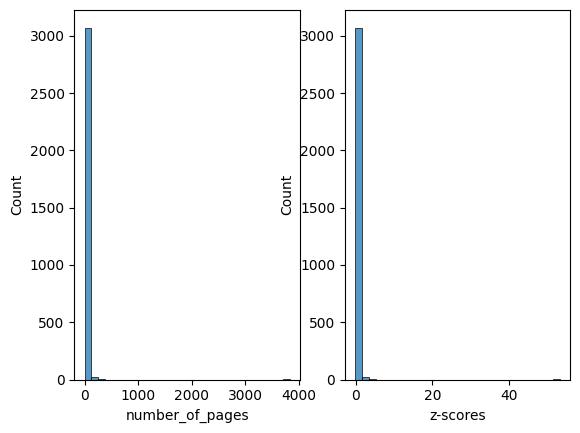

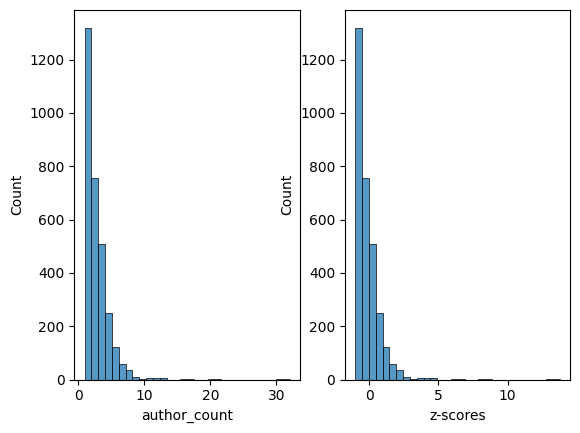

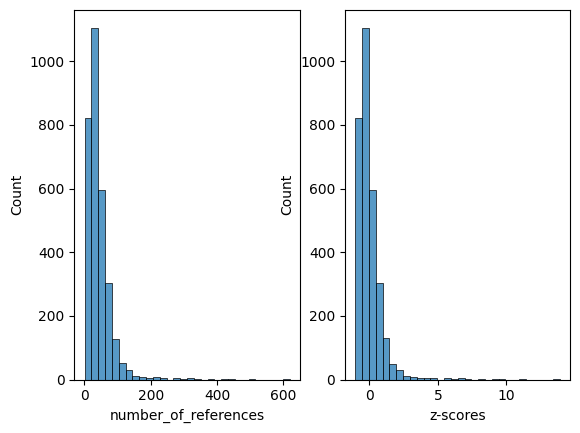

In [15]:
numerical_columns = ['citation_count_without_self_citations', 'citation_count', 'number_of_pages', 'author_count', 'number_of_references']

for col in numerical_columns:
    z_scores = (df[col] - df[col].mean()) / df[col].std()

    fig, axes = plt.subplots(1, 2)

    sns.histplot(data=df, x=col, bins=30, ax=axes[0])

    sns.histplot(z_scores, bins=30, ax=axes[1])
    axes[1].set_xlabel("z-scores")
    plt.show()

There are outliers for each columns. However, we know that there are different publication types and document types. Let's see its behavior for `number_of_references`.

In [17]:
for doc_type in df['document_type'].cat.categories:
    for pub_type in df['publication_type'].cat.categories:
        print(f'doc type: {doc_type}, pub_type: {pub_type}, {df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references' ].mean()}'  )

doc type: article, pub_type: lectures, nan
doc type: article, pub_type: research, 44.028169014084504
doc type: article, pub_type: review, 175.5681818181818
doc type: book chapter, pub_type: lectures, nan
doc type: book chapter, pub_type: research, 103.14285714285714
doc type: book chapter, pub_type: review, 104.0
doc type: conference paper, pub_type: lectures, 43.6
doc type: conference paper, pub_type: research, 25.12093023255814
doc type: conference paper, pub_type: review, 43.73684210526316
doc type: thesis, pub_type: lectures, nan
doc type: thesis, pub_type: research, 205.19230769230768
doc type: thesis, pub_type: review, nan


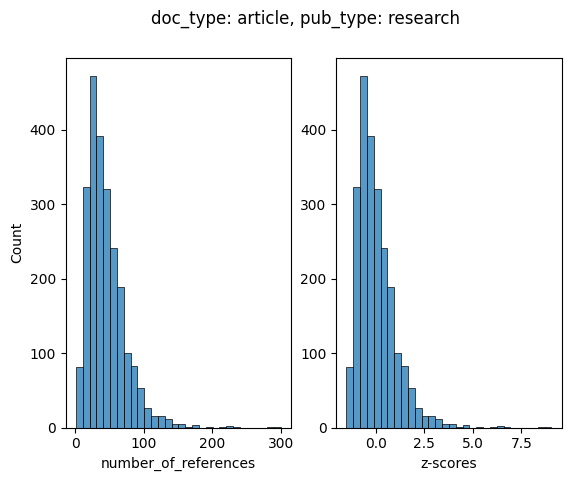

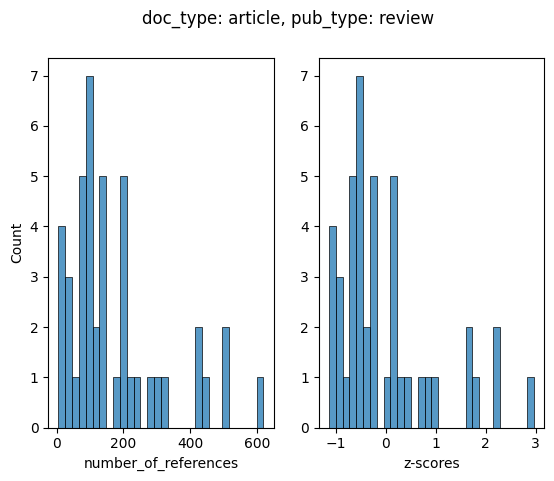

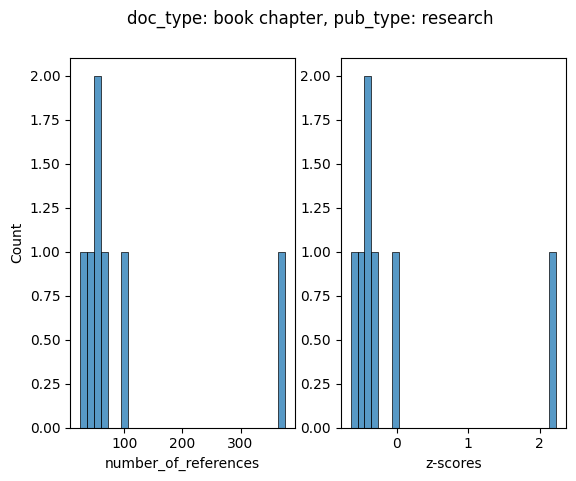

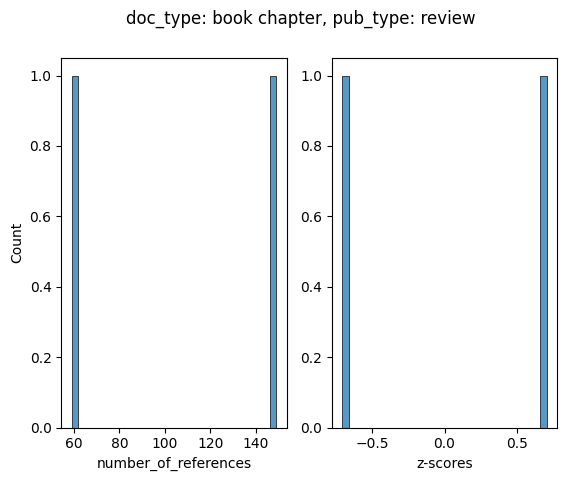

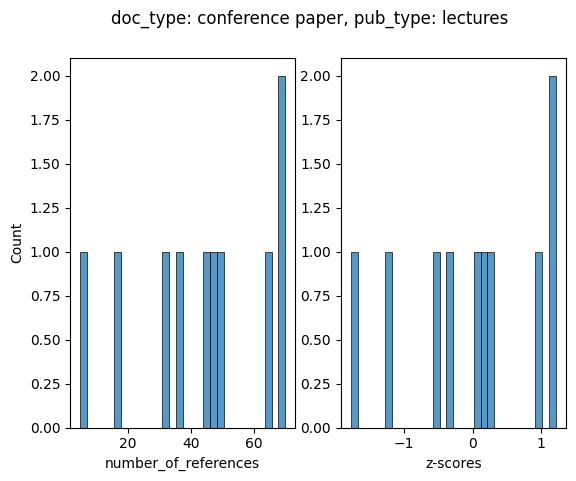

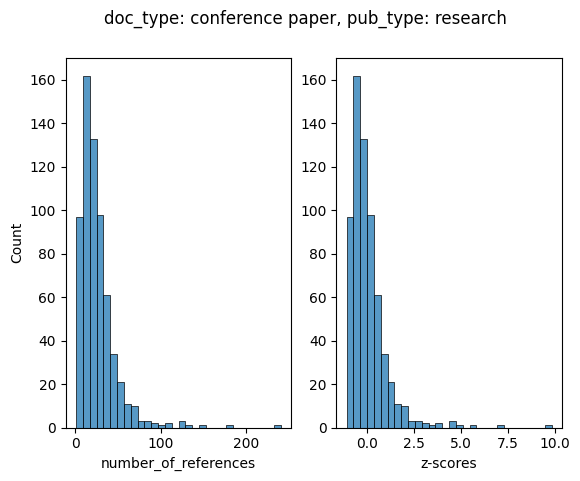

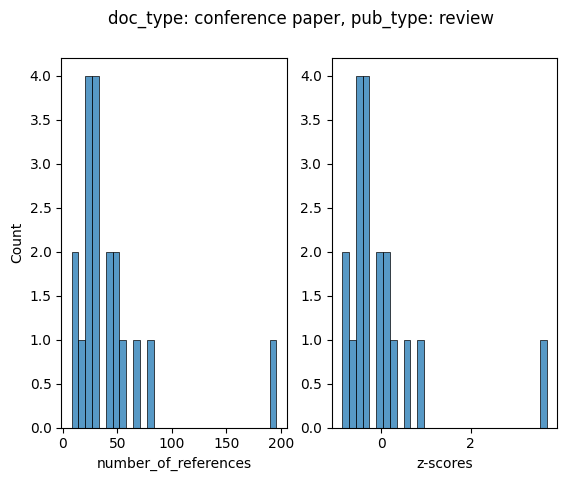

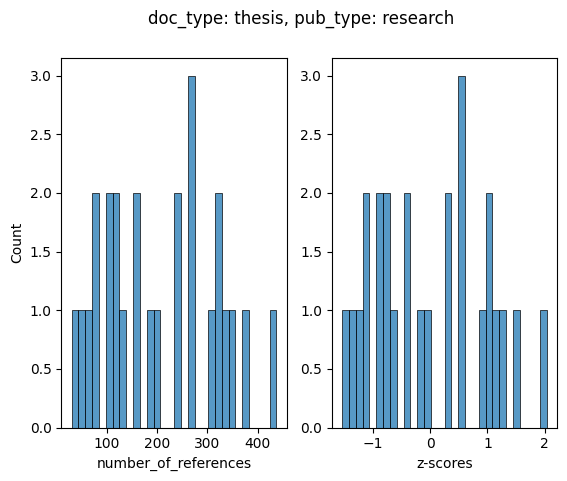

In [20]:
for doc_type in df['document_type'].cat.categories:
    for pub_type in df['publication_type'].cat.categories:
        if len(df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references' ]) > 1: # Only see if this category has more than 1 element

            df_temp = df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references' ]

            z_scores = (df_temp - df_temp.mean()) / df_temp.std()

            fig, axes = plt.subplots(1, 2)
            fig.suptitle(f"doc_type: {doc_type}, pub_type: {pub_type}")

            sns.histplot(data=df_temp, bins=30, ax=axes[0])

            sns.histplot(z_scores, bins=30, ax=axes[1])
            axes[1].set_xlabel("z-scores")
            axes[1].set_ylabel('')
            plt.show()

Even if we classified the papers using its type, still there are outliers. Let's remove them by the common threshold: if z-score is larger than 2 or smaller than -2, such outliers are removed.

In [22]:
for doc_type in df['document_type'].cat.categories:
    for pub_type in df['publication_type'].cat.categories:
        if len(df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references' ]) > 1: # Only see if this category has more than 1 element

            df_temp = df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references']

            z_scores = (df_temp - df_temp.mean()) / df_temp.std()

            outlier_indices = z_scores[np.abs(z_scores) > 2].index

            df = df.drop(outlier_indices)

See the results:

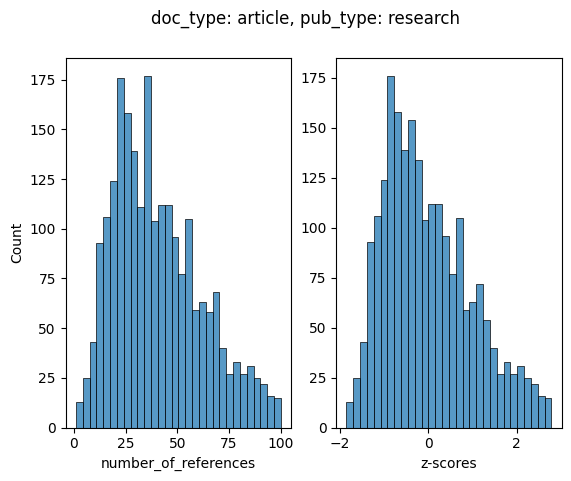

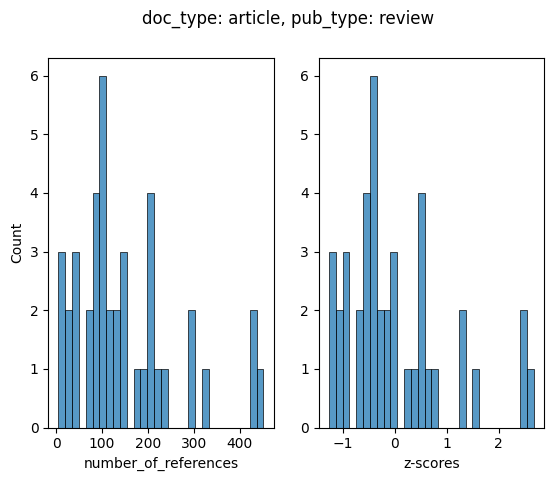

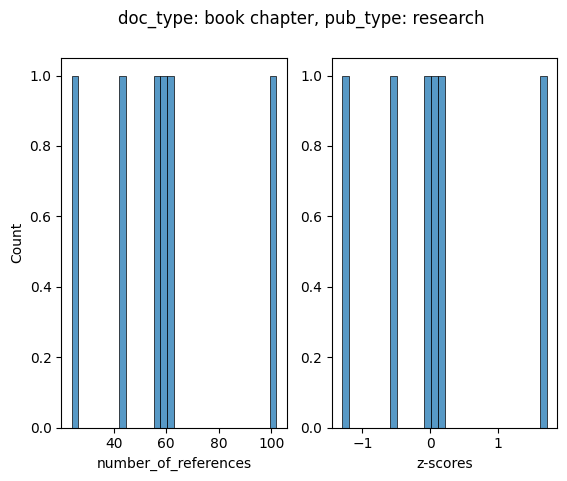

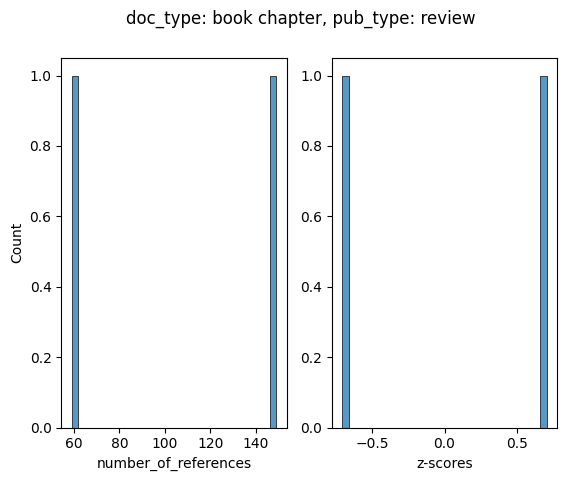

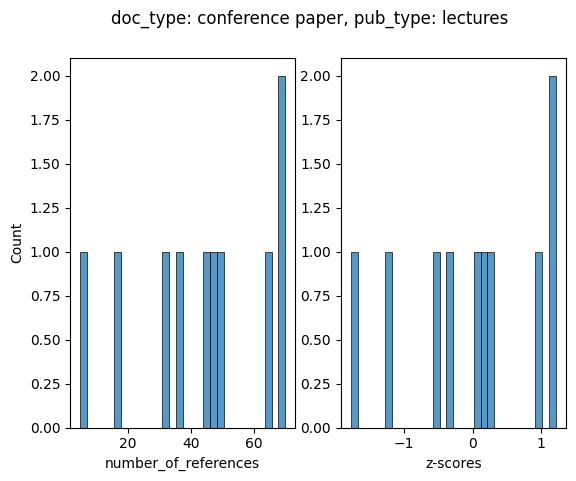

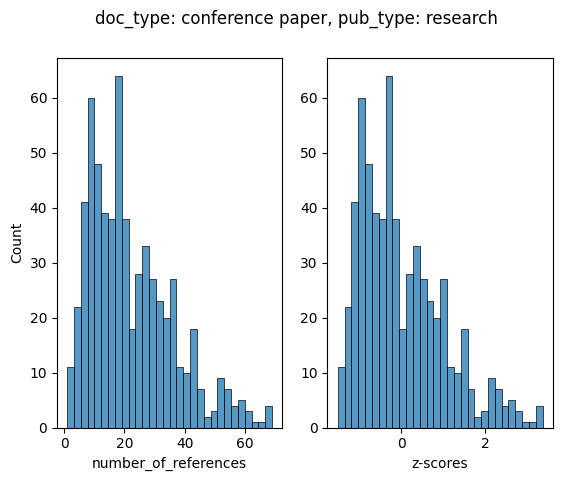

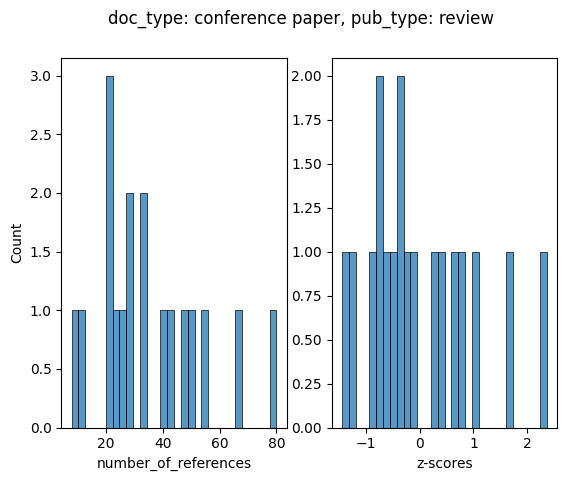

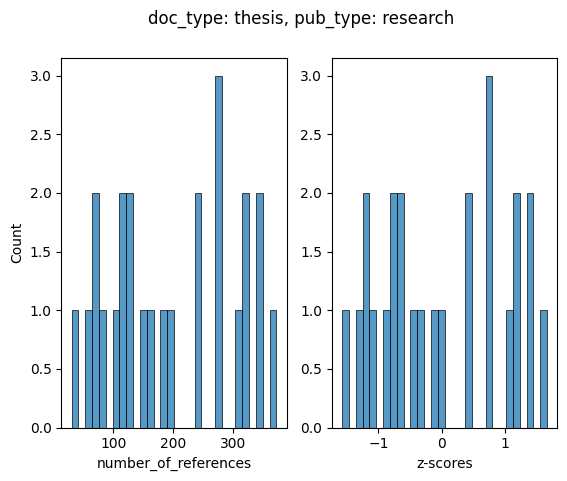

In [24]:
for doc_type in df['document_type'].cat.categories:
    for pub_type in df['publication_type'].cat.categories:
        if len(df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references' ]) > 1: # Only see if this category has more than 1 element

            df_temp = df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), 'number_of_references' ]

            z_scores = (df_temp - df_temp.mean()) / df_temp.std()

            fig, axes = plt.subplots(1, 2)
            fig.suptitle(f"doc_type: {doc_type}, pub_type: {pub_type}")

            sns.histplot(data=df_temp, bins=30, ax=axes[0])

            sns.histplot(z_scores, bins=30, ax=axes[1])
            axes[1].set_xlabel("z-scores")
            axes[1].set_ylabel('')
            plt.show()

In [25]:
df.shape

(2979, 10)

Outliers are removed. The papers with the absolute value of z-score larger than 2 are because mean and standard deviation are redefined. We did not handle this in pre-processing but it looks like it is needed to see the proper trend.

Summary statistics:

In [26]:
df.describe()

,id,citation_count_without_self_citations,citation_count,number_of_pages,preprint_date,author_count,number_of_references
count,2.979000e+03,2979.000000,2979.000000,2979.000000,2979,2979.000000,2979.000000
mean,1.152218e+06,23.210138,31.272239,15.406848,2010-01-23 11:16:15.226586112,3.097012,39.566969
min,4.000100e+04,0.000000,0.000000,1.000000,1995-01-01 00:00:00,1.000000,1.000000
25%,5.870675e+05,2.000000,3.000000,6.000000,2002-04-16 00:00:00,2.000000,20.000000
50%,8.460940e+05,7.000000,13.000000,10.000000,2010-01-01 00:00:00,3.000000,33.000000
75%,1.628164e+06,22.000000,33.000000,16.000000,2017-09-27 12:00:00,4.000000,52.000000
max,2.973744e+06,2317.000000,2329.000000,3826.000000,2025-09-27 00:00:00,32.000000,451.000000
std,7.066187e+05,66.164707,73.504285,72.522405,NaN,1.966728,33.003731


Before going further, let us save this cleaned data again.

In [27]:
df.to_csv("../data/data_nucl-th_100_cleaned.csv", index=False)

Let us see the distribution of numerical columns first

In [30]:
df = pd.read_csv("../data/data_nucl-th_100_cleaned.csv")

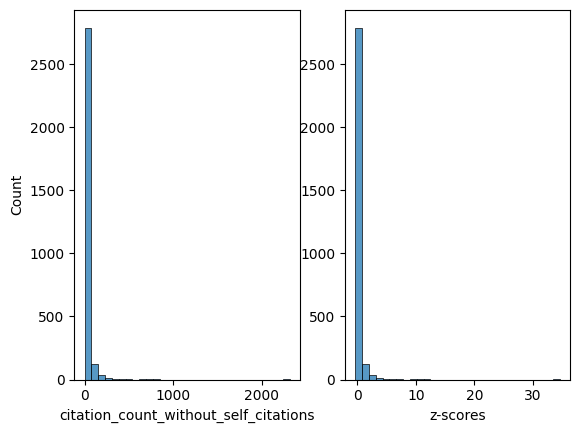

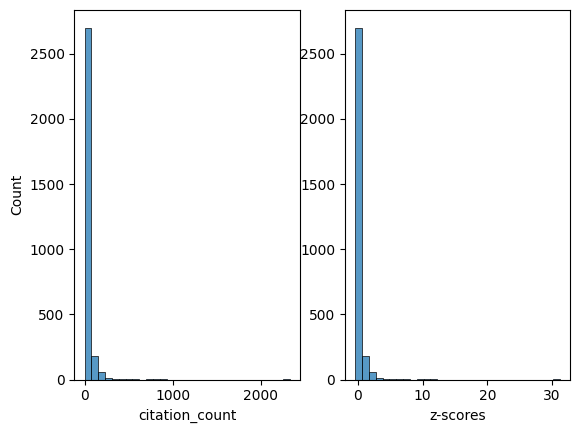

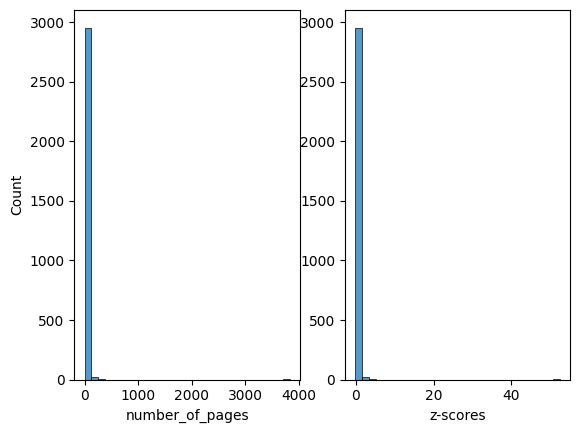

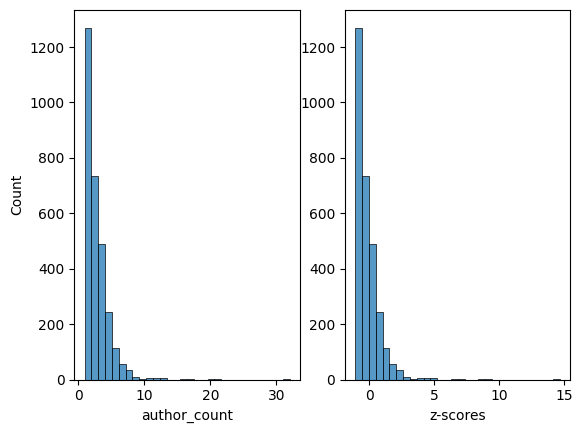

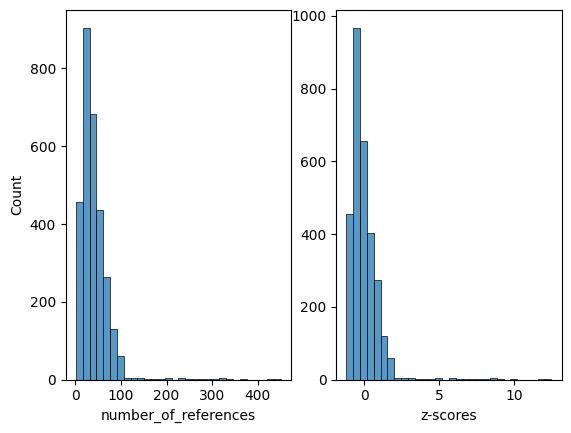

In [28]:
numerical_columns = ['citation_count_without_self_citations', 'citation_count', 'number_of_pages', 'author_count', 'number_of_references']

for col in numerical_columns:
    z_scores = (df[col] - df[col].mean()) / df[col].std()

    fig, axes = plt.subplots(1, 2)

    sns.histplot(data=df, x=col, bins=30, ax=axes[0])

    sns.histplot(z_scores, bins=30, ax=axes[1])
    axes[1].set_xlabel("z-scores")
    axes[1].set_ylabel("")
    plt.show()

They are more like exponential distribution with outliers (which is from different publication and document types). Next, let us consider other columns

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     2979 non-null   int64  
 1   citation_count_without_self_citations  2979 non-null   int64  
 2   citation_count                         2979 non-null   int64  
 3   number_of_pages                        2979 non-null   float64
 4   preprint_date                          2979 non-null   object 
 5   author_count                           2979 non-null   int64  
 6   refereed                               2979 non-null   bool   
 7   document_type                          2979 non-null   object 
 8   publication_type                       2979 non-null   object 
 9   number_of_references                   2979 non-null   int64  
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 212.5+ KB


It looks like categorical columns are reset when we reload it.

In [32]:
df['preprint_date'] = pd.to_datetime(df['preprint_date'], format='mixed', errors='coerce')
df['document_type'] = df['document_type'].astype('category')
df['publication_type'] = df['publication_type'].astype('category')

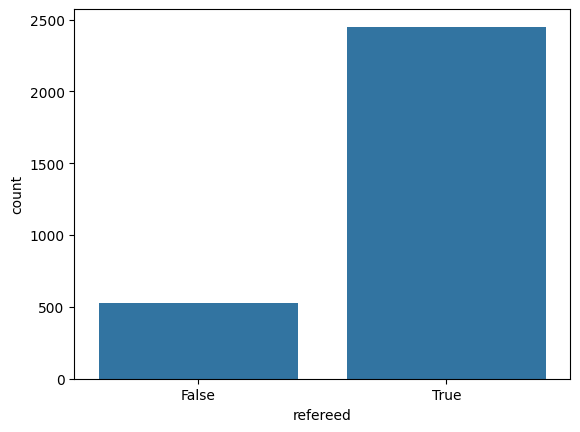

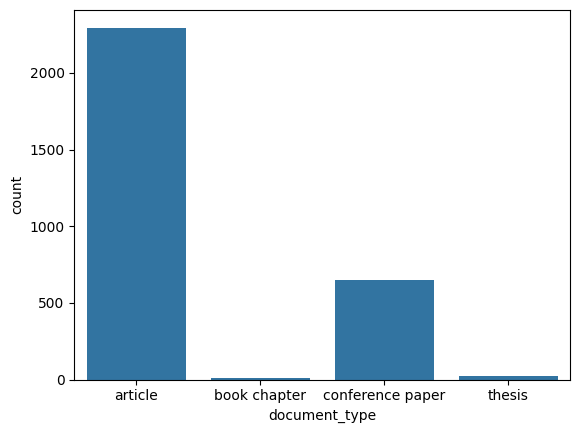

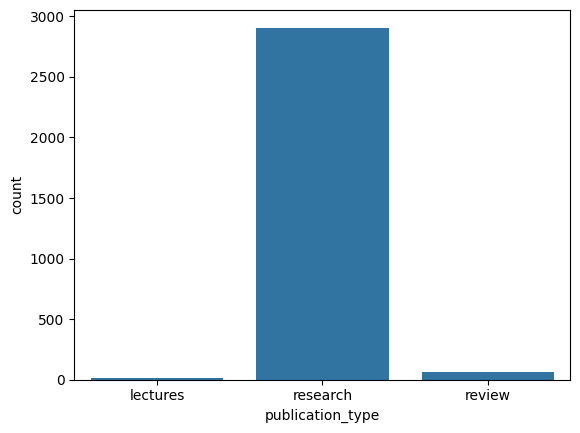

In [33]:
object_column = ['refereed', 'document_type', 'publication_type']

for col in object_column:
    sns.countplot(data=df, x=col)
    plt.show()

For `preprint_date`, let us plot yearly for better visualization.

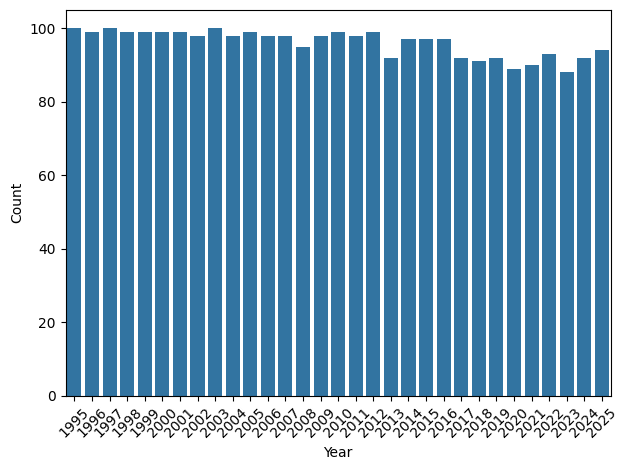

In [34]:
yearly = df['preprint_date'].dt.year

yearly_counts = yearly.value_counts().sort_index().reset_index()
yearly_counts.columns = ['year', 'count']


sns.barplot(data=yearly_counts, x='year', y='count')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It is expected because we did stratified sampling by choosng 100 random samples from each year. It looks like outliers appear more as the year increases.

## Relationships between variables

First guess is that `citation_count_without_self_citations` must depend on `citation_count`. Also, `number_of_references` should be positively correlated with `number_of_pages`, `author_count`.

Let us check the correlation first.

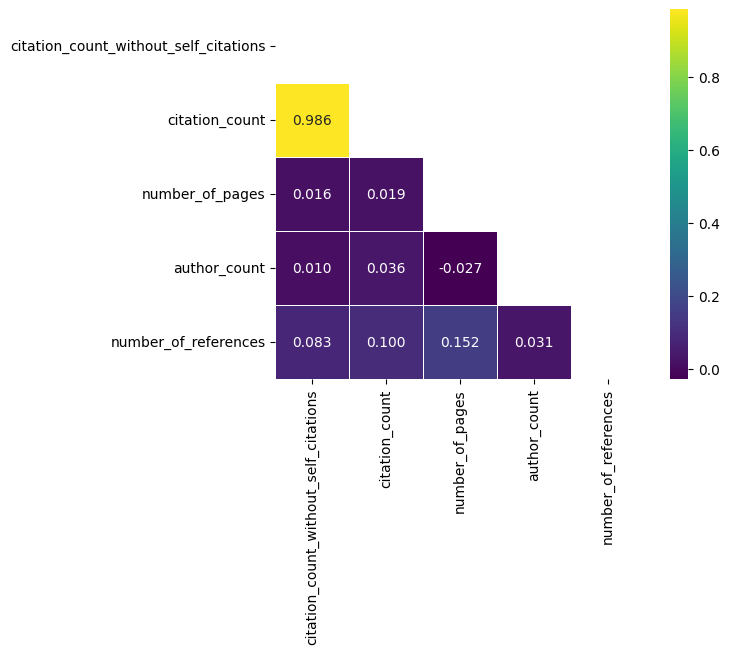

In [35]:
corr = df[numerical_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool) )

sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap='viridis', linewidths=0.5, square=True)
plt.show()

It looks like `citation_count` and `citation_count_without_self_citations` are highly correlated, which is natural, and `number_of_pages` and `number_of_references` are more correlated than others.

Let us consider this for different categories as before:

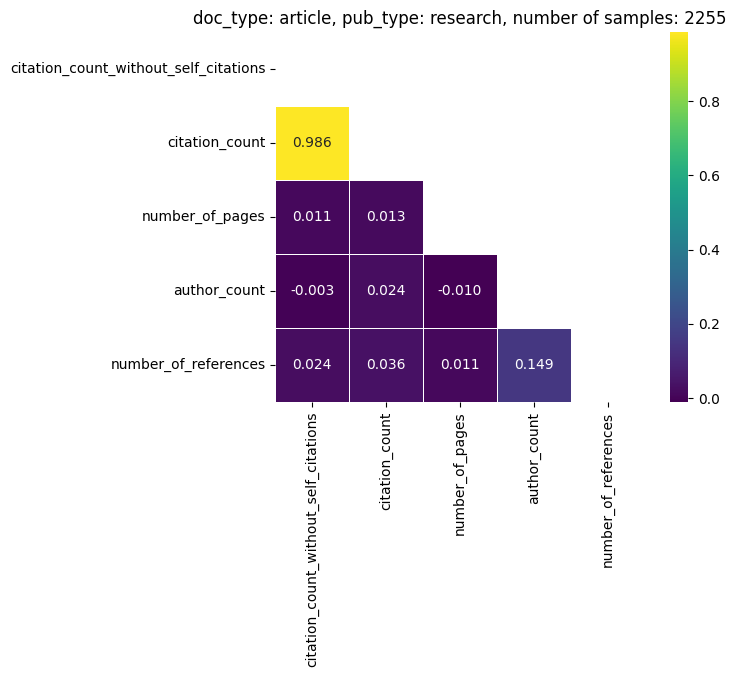

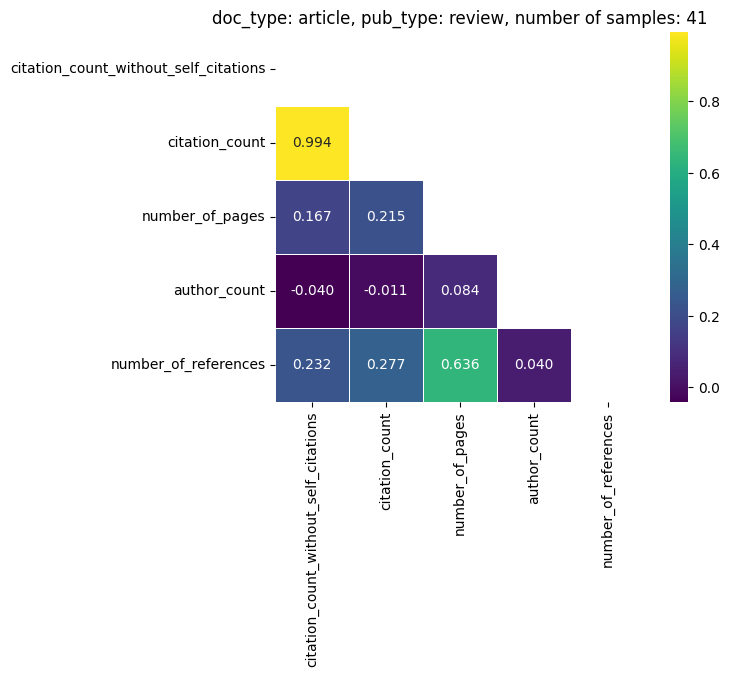

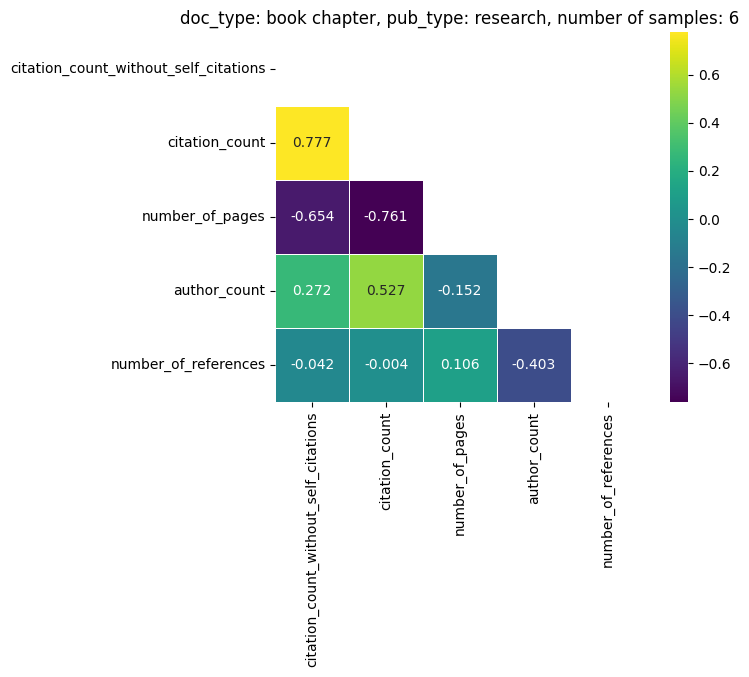

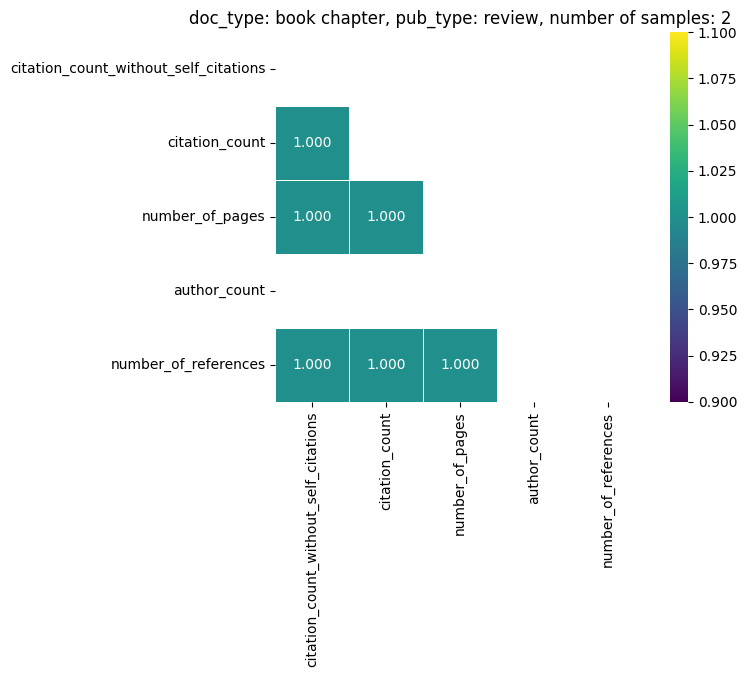

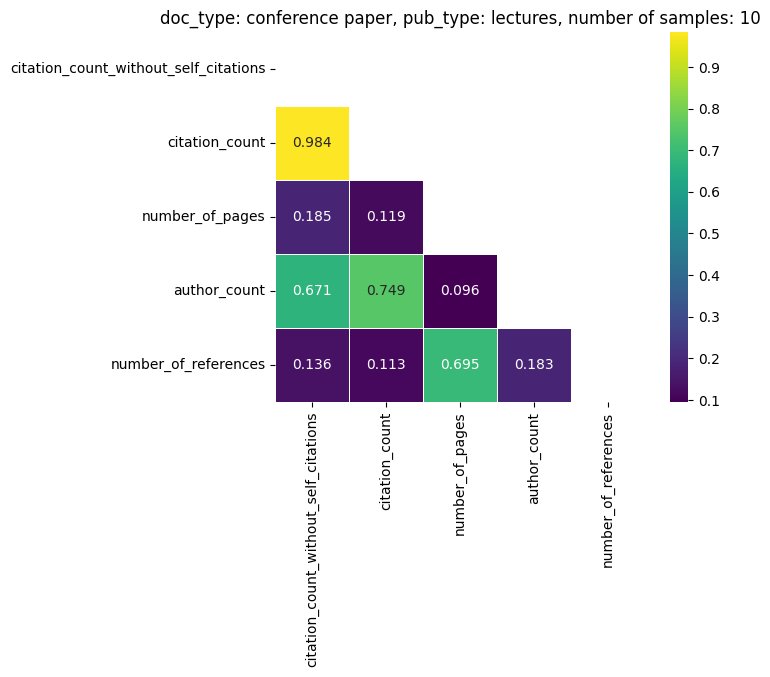

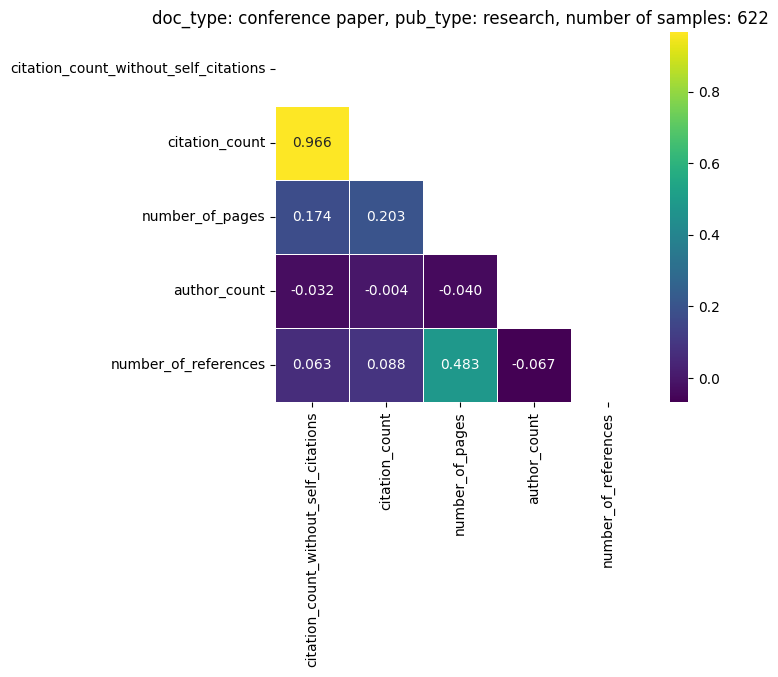

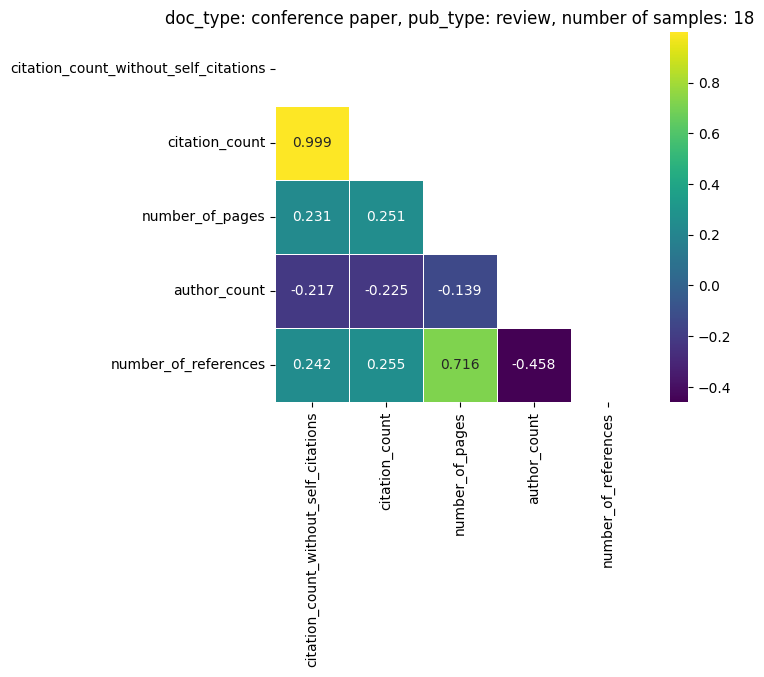

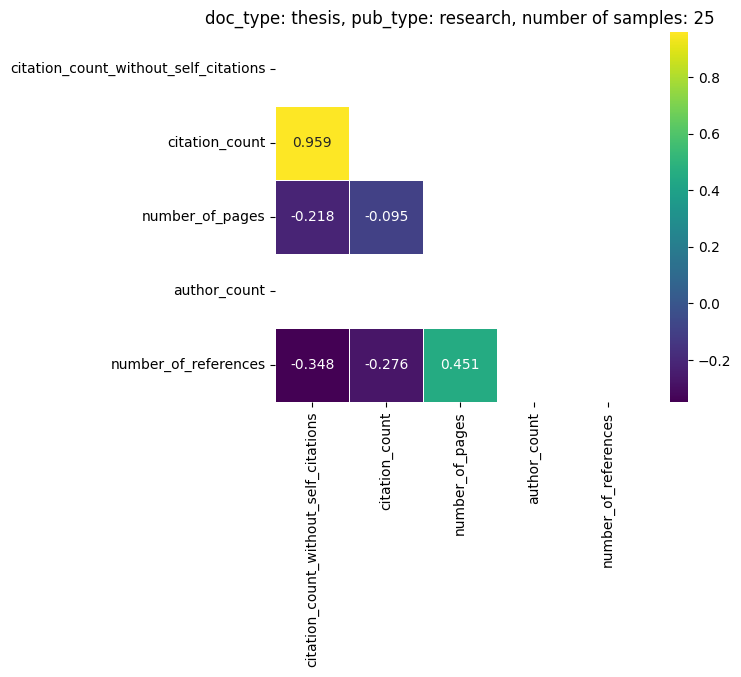

In [38]:
for doc_type in df['document_type'].cat.categories:
    for pub_type in df['publication_type'].cat.categories:
        if len(df[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type)]) > 1: # Only see if this category has more than 1 element

            df_temp = df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), numerical_columns ]
            n_samples = len(df_temp)

            corr = df_temp.corr()

            mask = np.triu(np.ones_like(corr, dtype=bool) )

            plt.title(f"doc_type: {doc_type}, pub_type: {pub_type}, number of samples: {n_samples}")

            sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap='viridis', linewidths=0.5, square=True)
            plt.show()

Number of samples for categories are small except `doc_type=article`, `pub_type=research` and `doc_type=conference paper`, `pub_type=research`. For conference papers, `number_of_pages` and `number_of_references` are highly correlated (0.541).

While there are different correlation behaviors for other cases, since the number of samples are low, it is hard to say it represents Simpson's paradox. Let us only consider cases with $n_{\rm samples} \ge 30$ in detail.

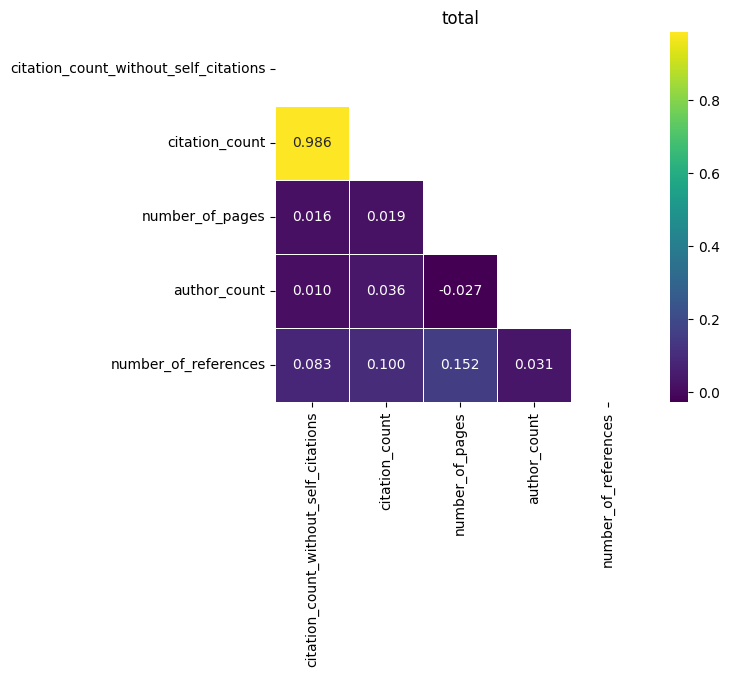

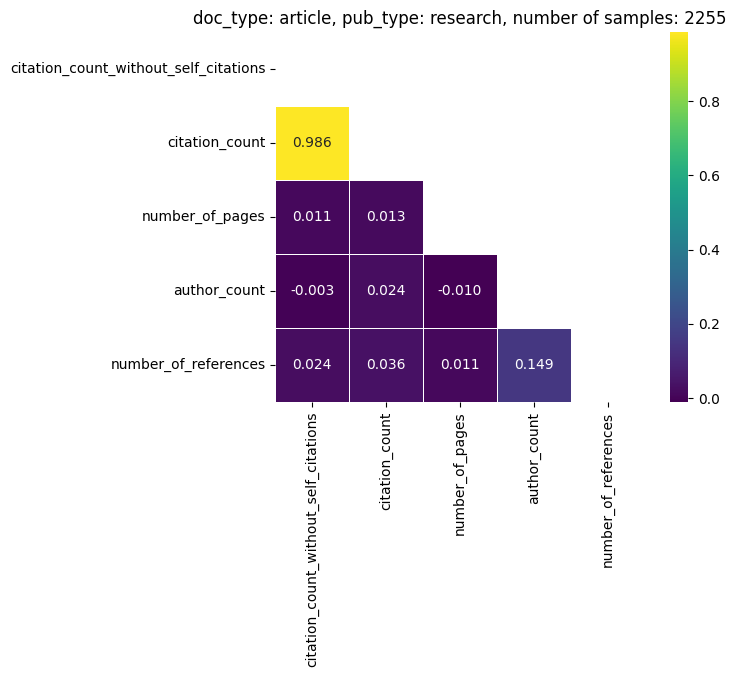

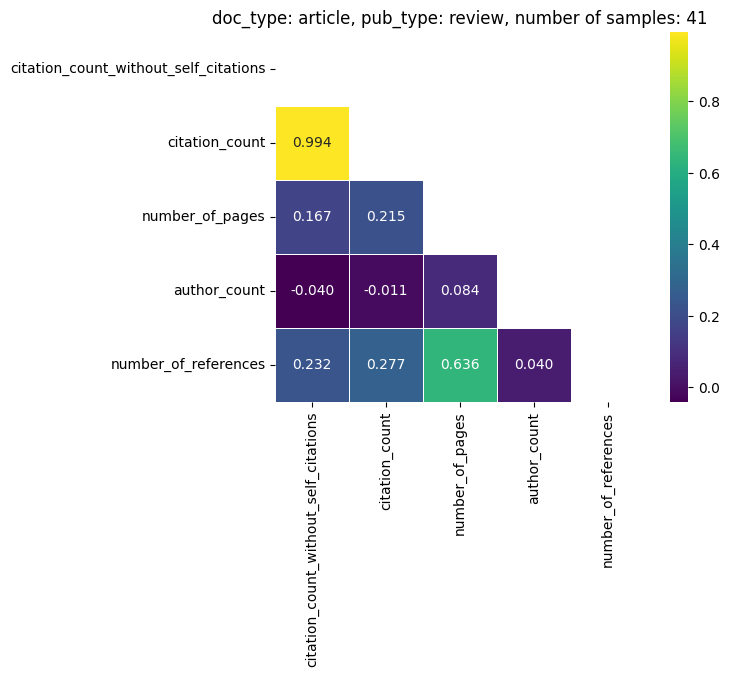

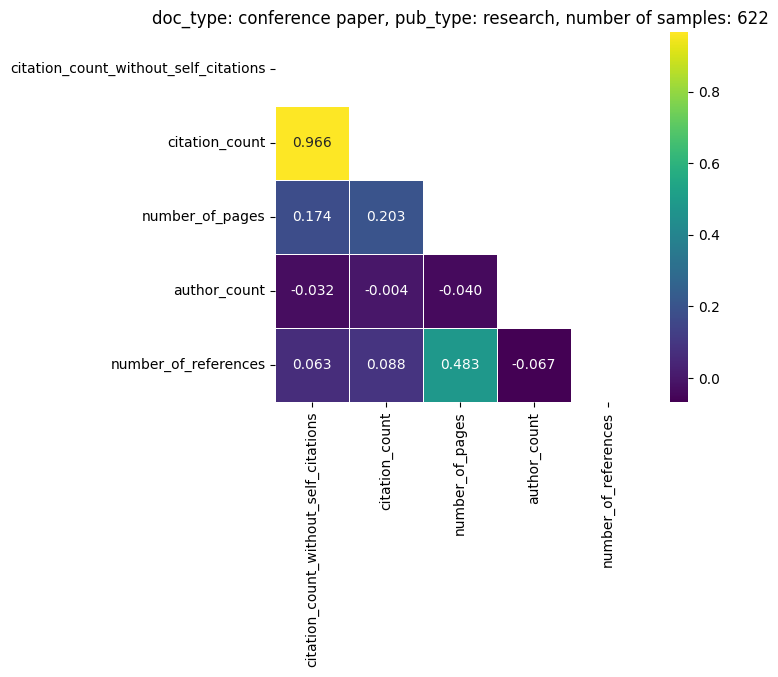

In [41]:
corr_total = df[numerical_columns].corr()

mask = np.triu(np.ones_like(corr_total, dtype=bool) )

plt.title("total")
sns.heatmap(corr_total, mask=mask, annot=True, fmt=".3f", cmap='viridis', linewidths=0.5, square=True)
plt.show()


for doc_type in df['document_type'].cat.categories:
    for pub_type in df['publication_type'].cat.categories:
        if len(df[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type)]) > 1: # Only see if this category has more than 1 element
            df_temp = df.loc[(df['document_type'] == doc_type) & (df['publication_type'] == pub_type), numerical_columns ]
            n_samples = len(df_temp)
            if n_samples>=30:


                corr = df_temp.corr()
                mask = np.triu(np.ones_like(corr, dtype=bool) )


                sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap='viridis', linewidths=0.5, square=True)
                plt.title(f"doc_type: {doc_type}, pub_type: {pub_type}, number of samples: {n_samples}")

                plt.show()

One example of Simpson's paradox is that review papers have negative correlation between `author_count` and `citation_count`. However, the absolute value itself is small so it is not a dramatic Simpson's paradox.


Additionally, `number_of_pages` is highly correlated with `number_of_references` as conference proceedings.

Lastly, let us see the most important point for the claim: the dependency of the number of references and preprint date.

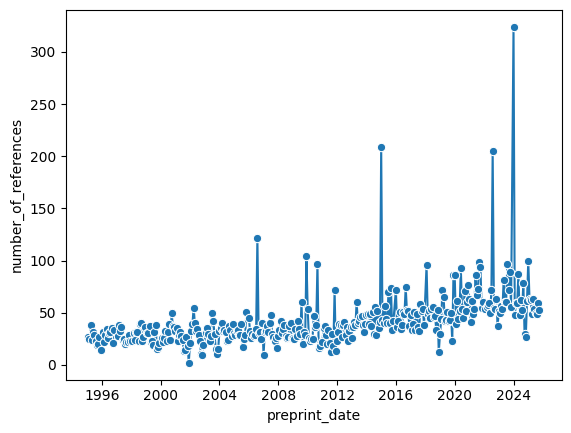

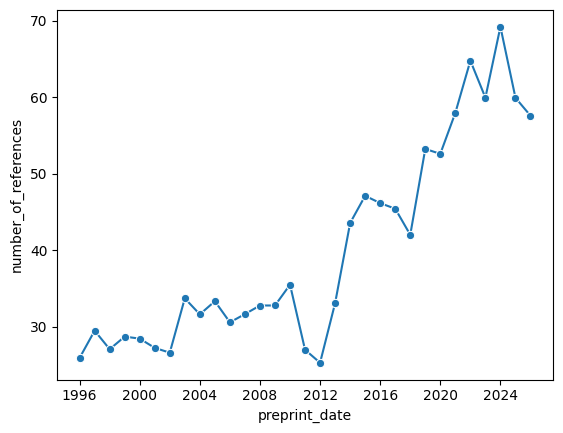

In [42]:
df_temp = df.set_index('preprint_date')

monthly_avg = df_temp['number_of_references'].resample('ME').mean()

sns.lineplot(monthly_avg, marker='o')
plt.show()

yearly_avg = df_temp['number_of_references'].resample('YE').mean()

sns.lineplot(yearly_avg, marker='o')
plt.show()

From yearly average, it definitely has positive correlation with time and the number of references. Let us only consider articles.

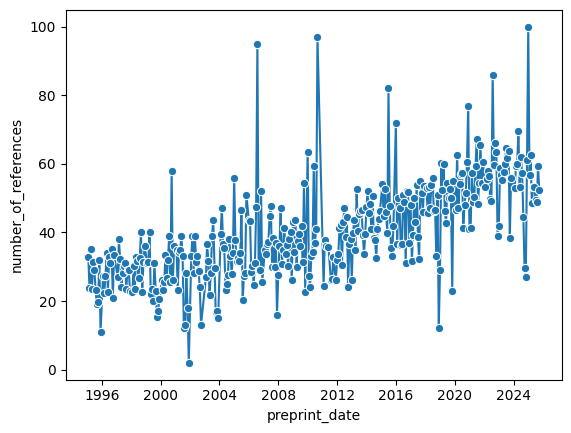

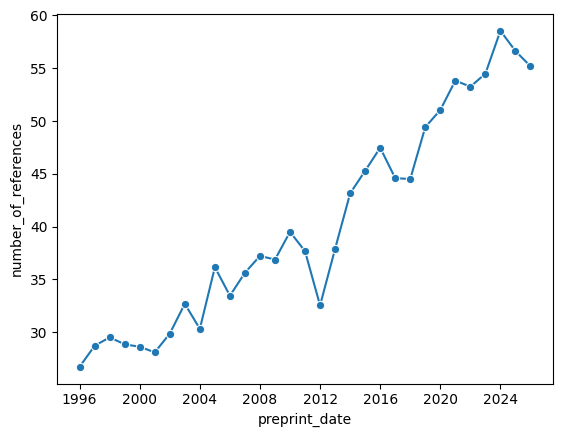

In [43]:
df_temp = df[(df['document_type']=='article') & (df['publication_type']=='research')].set_index('preprint_date')

monthly_avg = df_temp['number_of_references'].resample('ME').mean()

sns.lineplot(monthly_avg, marker='o')
plt.show()

yearly_avg = df_temp['number_of_references'].resample('YE').mean()

sns.lineplot(yearly_avg, marker='o')
plt.show()

This one is more linear than all articles.


Next, let us consider proceedings.

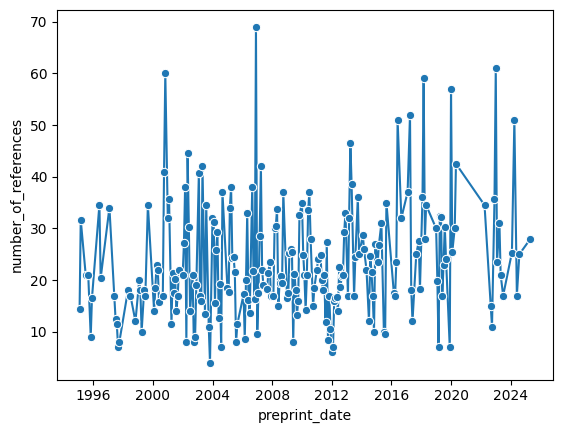

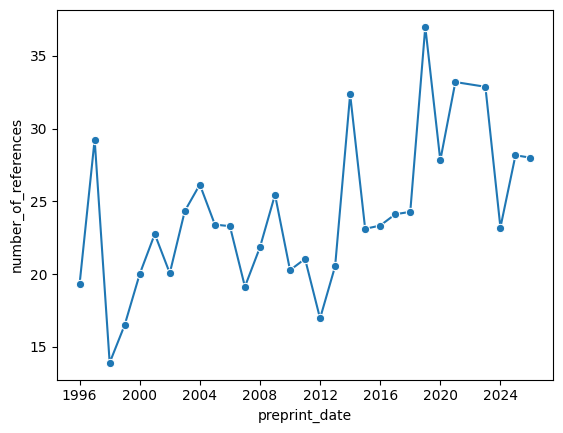

In [44]:
df_temp = df[(df['document_type']=='conference paper') & (df['publication_type']=='research')].set_index('preprint_date')

monthly_avg = df_temp['number_of_references'].resample('ME').mean()

sns.lineplot(monthly_avg, marker='o')
plt.show()

yearly_avg = df_temp['number_of_references'].resample('YE').mean()

sns.lineplot(yearly_avg, marker='o')
plt.show()

For proceedings, it looks like there is positive correlation but not dramatic as peer-reviewed articles.

## Trustability of the dataset

This dataset is trustable because visualizations show expected behavior. For example, conference proceedings tend to have word limits and so if the number of pages is small, people tend to reduce the number of references. For review papers, the number of pages is also correlated with citation count and it is because longer publication tends to have deeper, or wider review so that people cite.



## Wrap up

From data exploration process, we studied the data itself from visualizations. From this, we learned that the paper type is important for analyzing the trend. Also, outliers are removed using z-score and visualizations.

The key insight from this process is that from the last visualization, our hypothesis looks true so that we do not have to change our hypothesis. However, it is very interesting that for articles, it seems like that the trend has been increasing linearly, which we need to check in the next session.

One point that we can study using this data is the trend for the self-citations. Since it can be calculated as `citation_count` - `citation_count_without_self_citations`, we can study this easily.


In one sense, we can restrict the paper type to articles, because they are the most typical type, which we usually refer as "papers". For other classes, the number of samples are small so if we want to study such classes, we can think about getting more samples.

# Modeling

## What kind of models do we consider?

Since we are interested in the behavior of number of references in time, it is a regression problem, which belongs to a supervised learning.

From data exploration process, it seems like the trend is linear. Therefore, we first consider polynomial regressions and to consider fluctuations, we we can consider tools from time series analysis.

## Features

In [46]:
print(df.shape)
df.head()

(2979, 10)


,id,citation_count_without_self_citations,citation_count,number_of_pages,preprint_date,author_count,refereed,document_type,publication_type,number_of_references
0,1459726,10,20,20.0,1995-03-28,3,True,article,research,41
1,1459842,4,4,5.0,1995-04-07,2,True,article,research,19
2,1460442,47,51,6.0,1995-01-17,2,True,article,research,17
3,392718,1,1,12.0,1995-01-01,2,False,conference paper,research,16
4,397533,65,67,4.0,1995-07-01,2,True,article,research,17


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   id                                     2979 non-null   int64         
 1   citation_count_without_self_citations  2979 non-null   int64         
 2   citation_count                         2979 non-null   int64         
 3   number_of_pages                        2979 non-null   float64       
 4   preprint_date                          2979 non-null   datetime64[ns]
 5   author_count                           2979 non-null   int64         
 6   refereed                               2979 non-null   bool          
 7   document_type                          2979 non-null   category      
 8   publication_type                       2979 non-null   category      
 9   number_of_references                   2979 non-null   int64   

The basic features we need to consider is `number_of_pages`, `preprint_date`, `author_count` and `number_of_references`. We can consider `document_type` and `publication_type` as an input for the model or consider different models for different types of papers.

> `number_of_pages`: If paper is longer, it can have more references. It is discrete data type with int.
>
> `preprint_date`: The number of references has been increasing over time. It is datetime type.
>
> `author_count`: If there are more authors, there will be more references if each author can contribute to references equally. It is discrete data type with int.
>
> `document_type`: Document type can affect the number of references. For example, conference papers often have length limits so that they cannot add too many references. It is a categorical variable whose categories are 'article', 'conference paper', 'book chapter', and 'thesis'.
>
> `publication_type`: Document type can affect the number of references. For example, reviews tend to have a lot of references. It is a categorical variable whose categories are 'research', 'review', and 'lectures'.
>
> `number_of_references`: It is what we want to predict.


For `refereed` column, we know that only research papers are peer-reviewed and this information is encoded in `document_type` and `publication_type`, so we can remove it.

Therefore, let's remove unnecessary columns.

In [48]:
df = df.drop(columns=['id', 'citation_count_without_self_citations', 'citation_count', 'refereed'])

df.shape

(2979, 6)

There are total ~35,000 papers whose primary arXiv category is 'nucl-th' and we selected 3100 papers. Since the authors might overlap for different papers, it is hard to say that each papers are independent, while I guess they are nearly independent.

From the data visualization, many features are not normally distributed.

In [50]:
import requests

# Check the number of papers with primary arxiv category is 'nucl-th'.
url = "https://inspirehep.net/api/literature"
params = {"q": "primary_arxiv_category:nucl-th", "size": 1}
response = requests.get(url, params=params).json()
print(response["hits"]["total"])

34930


The benefit of the reducing dimensionality is for interpretability, better optimization performance, avoiding overfitting. Having higher dimensionality implies that one needs more parameters for the same model and it will complicate the loss landscape. Also, in general, the data is limited so more parameters can affect overfitting.

## Algorithms

We are considering linear regression and tree-based approaches for regression problem.

Linear regression assumes that the relationship between predictors and target is linear. Also, it assumes that the residuals ($y-\hat{y}$) are normally distributed.

Tree-based methods are non-parametric model, so they do not have particular assumptions. However, it implicitly assumes that the data points are roughly i.i.d.


Both algorithms can have overfitting. Here, since there are not many features even if we do one-hot encoding for categorical variables, linear regression can be nearly free from the overfitting. However, tree-based models can suffer from overfitting if we do not restrict its depth or stopping criteria.


These algorithms are good enough for our case since there are not many features and we have relatively enough data points.

## Hyperparmeters to be considered

For linear regression, we can consider $L_2$ regularization parameter $\alpha$.

For tree-based methods, we can consider three algorithms: decision tree, random forest, and XGBoost.

For decision tree, we need to consider `max_depth`, `min_samples_split`, and `min_samples_leaf`, `max_features`, and `ccp_alpha`.

For random forest, we need to consider `n_estimators`, `max_features`, `max_depth`, `min_samples_split`, and `min_sample_leaf`.

For XGBoost, we need to consider `n_estimators`, `learning_rate`, and `max_depth`.

## Post-processing techniques

For tree-based methods, we can consider post-prunning.

## Training

### Prepare training, test set

We will use cross validation, so we will not separate training and validation set.

In [51]:
# change preprint_date (datetime) to float

base_date = pd.to_datetime('1995-01-01') # We sampled data from 1995, so it it a base date.

df['preprint_date_numeric'] = (df['preprint_date'] - base_date) / np.timedelta64(1, 'D')
df = df.drop(columns=['preprint_date'])

df

,number_of_pages,author_count,document_type,publication_type,number_of_references,preprint_date_numeric
0,20.0,3,article,research,41,86.0
1,5.0,2,article,research,19,96.0
2,6.0,2,article,research,17,16.0
3,12.0,2,conference paper,research,16,0.0
4,4.0,2,article,research,17,181.0
...,...,...,...,...,...,...
2974,18.0,5,article,research,79,11142.0
2975,19.0,2,article,research,41,11160.0
2976,11.0,8,article,research,48,11219.0
2977,9.0,3,article,research,35,11114.0


In [118]:
from sklearn.model_selection import train_test_split

seed=42

# Training:Test = 8:2
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)

y_train = df_train['number_of_references'].to_numpy()
y_test = df_test['number_of_references'].to_numpy()

df_train = df_train.drop('number_of_references', axis=1)
df_test = df_test.drop('number_of_references', axis=1)

# One-hot encoding
df_train = pd.get_dummies(df_train, columns=['document_type', 'publication_type'])
df_test = pd.get_dummies(df_test, columns=['document_type', 'publication_type'])

# Change boolean dtype to int
df_train[df_train.select_dtypes(bool).columns] = df_train.select_dtypes(bool).astype(int)
df_test[df_test.select_dtypes(bool).columns] = df_test.select_dtypes(bool).astype(int)

# Change int type to float for regression problem
df_train[df_train.select_dtypes(int).columns] = df_train.select_dtypes(int).astype(float)
df_test[df_test.select_dtypes(int).columns] = df_test.select_dtypes(int).astype(float)

In [55]:
df_test

,number_of_pages,author_count,preprint_date_numeric,document_type_article,document_type_book chapter,document_type_conference paper,document_type_thesis,publication_type_lectures,publication_type_research,publication_type_review
2406,2.0,6.0,8947.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2236,10.0,4.0,8202.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2298,14.0,4.0,8513.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1818,16.0,2.0,6742.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2797,11.0,7.0,10640.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
998,14.0,6.0,3804.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
422,24.0,2.0,1492.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
767,25.0,2.0,2677.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1271,3.0,2.0,4564.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Linear regression

In [56]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model= Pipeline([
    ('scaler', MinMaxScaler()), # Scaling is needed for preprint_date_numeric. MinMax is better since preprint_date_numeric is kind of uniform distribution.
    ('ridge', Ridge())
])


param_grid = {
    'ridge__alpha': np.logspace(-5, 4, 30)
}

ridge_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

ridge_search.fit(df_train, y_train)

y_test_pred = ridge_search.predict(df_test)


print(f"Best hyperparmeters: {ridge_search.best_params_}")
print(f"MSE: {-ridge_search.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparmeters: {'ridge__alpha': np.float64(32.90344562312671)}
MSE: 758.8484927279262


### Tree-based methods

##### Decision tree

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': uniform(0.0, 0.1)
}


model = DecisionTreeRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(df_train, y_train)

y_test_pred = random_search.predict(df_test)

print(f"Best hyperparmeters: {random_search.best_params_}")
print(f"MSE: {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparmeters: {'ccp_alpha': np.float64(0.09654193512887937), 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 10}
MSE: 464.6901089106033


#### Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(5, 50),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
}


model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(df_train, y_train)

y_test_pred = random_search.predict(df_test)

print(f"Best hyperparmeters: {random_search.best_params_}")
print(f"MSE: {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparmeters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 48}
MSE: 416.95330258189404


#### XGBoost

In [59]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(5, 50),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(1e-3, 5e-1)
}


model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(df_train, y_train)

y_test_pred = random_search.predict(df_test)

print(f"Best hyperparmeters: {random_search.best_params_}")
print(f"MSE: {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparmeters: {'learning_rate': np.float64(0.32644423647442644), 'max_depth': 4, 'n_estimators': 28}
MSE: 416.7034973144531


XG Boost has the best performance!

### Only for article

In [124]:
from sklearn.model_selection import train_test_split

dfa = df[df['document_type']=='article']

seed=42

# Training:Test = 8:2
dfa_train, dfa_test = train_test_split(dfa, test_size=0.2, random_state=seed)

ya_train = dfa_train['number_of_references'].to_numpy()
ya_test = dfa_test['number_of_references'].to_numpy()

dfa_train = dfa_train.drop('number_of_references', axis=1)
dfa_test = dfa_test.drop('number_of_references', axis=1)

# One-hot encoding
dfa_train = pd.get_dummies(dfa_train, columns=['document_type', 'publication_type'])
dfa_test = pd.get_dummies(dfa_test, columns=['document_type', 'publication_type'])

# Change boolean dtype to int
dfa_train[dfa_train.select_dtypes(bool).columns] = dfa_train.select_dtypes(bool).astype(int)
dfa_test[dfa_test.select_dtypes(bool).columns] = dfa_test.select_dtypes(bool).astype(int)

# Change int type to float for regression problem
dfa_train[dfa_train.select_dtypes(int).columns] = dfa_train.select_dtypes(int).astype(float)
dfa_test[dfa_test.select_dtypes(int).columns] = dfa_test.select_dtypes(int).astype(float)

#### Linear regression

In [127]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model= Pipeline([
    ('scaler', MinMaxScaler()), # Scaling is needed for preprint_date_numeric. MinMax is better since preprint_date_numeric is kind of uniform distribution.
    ('ridge', Ridge())
])


param_grid = {
    'ridge__alpha': np.logspace(-5, 4, 30)
}

ridge_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

ridge_search.fit(dfa_train, ya_train)

ya_test_pred = ridge_search.predict(dfa_test)


print(f"Best hyperparmeters: {ridge_search.best_params_}")
print(f"MSE: {-ridge_search.best_score_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparmeters: {'ridge__alpha': np.float64(0.22122162910704501)}
MSE: 474.7666809968394


#### Tree-based methods

##### Decision tree

In [129]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': uniform(0.0, 0.1)
}


model = DecisionTreeRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(dfa_train, ya_train)

ya_test_pred = random_search.predict(df_test)

print(f"Best hyperparmeters: {random_search.best_params_}")
print(f"MSE: {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparmeters: {'ccp_alpha': np.float64(0.071134195274865), 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 11}
MSE: 417.2348745301555


##### Random Forest

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(5, 50),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'sqrt', 'log2'],
}


model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(dfa_train, ya_train)

ya_test_pred = random_search.predict(df_test)

print(f"Best hyperparmeters: {random_search.best_params_}")
print(f"MSE: {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparmeters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 48}
MSE: 383.15793115502504


##### XGBoost

In [134]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(5, 50),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(1e-3, 5e-1)
}


model = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(dfa_train, ya_train)

ya_test_pred = random_search.predict(dfa_test)

print(f"Best hyperparmeters: {random_search.best_params_}")
print(f"MSE: {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparmeters: {'learning_rate': np.float64(0.36550358402049365), 'max_depth': 3, 'n_estimators': 9}
MSE: 391.8536865234375


For articles, random forest has the best performance.

### Final model

In [117]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

model = XGBRegressor(
    n_estimators=28,
    max_depth=4,
    learning_rate=0.32644423647442644,
    random_state=42,
    n_jobs=-1
)
model.fit(df_train, y_train)

y_test_pred = model.predict(df_test)

print(f"MSE: {mean_squared_error(y_test, y_test_pred)}")

MSE: 781.5403442382812


In [ ]:
import pickle

with open("../bin/model.pkl", "wb") as file:
    pickle.dump(model, file)

#### Model only for articles

In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model_article = RandomForestRegressor(
    n_estimators = 48,
    max_depth = 7,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features=None,
    random_state=42,
    n_jobs= -1
)

model_article.fit(dfa_train, ya_train)

ya_test_pred = model_article.predict(dfa_test)

print(f"MSE: {mean_squared_error(ya_test, ya_test_pred)}")

MSE: 475.996608697814


In [ ]:
import pickle

with open("../bin/model_article.pkl", "wb") as file:
    pickle.dump(model_article, file)

# Visualization

In [157]:
with open("../bin/model.pkl", "rb") as file:
    model = pickle.load(file)

y_test_pred = model.predict(df_test)

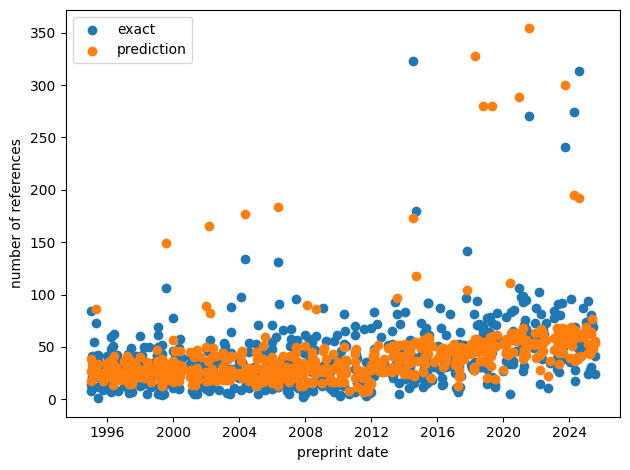

In [211]:
import matplotlib.pyplot as plt

base_date = pd.to_datetime('1995-01-01') 

test_date = base_date + pd.to_timedelta(df_test['preprint_date_numeric'], unit='D')

plt.scatter(test_date, y_test, label='exact')
plt.scatter(test_date, y_test_pred, label='prediction')
plt.xlabel('preprint date')
plt.ylabel('number of references')
plt.tight_layout()
plt.legend()

plt.show()

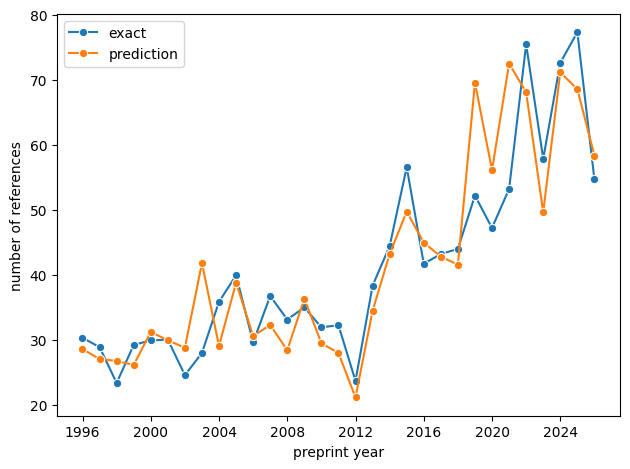

In [212]:
df1 = pd.DataFrame({'preprint_date': test_date, 'number_of_references':y_test}).set_index('preprint_date')
df2 = pd.DataFrame({'preprint_date': test_date, 'number_of_references':y_test_pred}).set_index('preprint_date')

yearly_avg_test = df1['number_of_references'].resample('YE').mean()
yearly_avg_pred = df2['number_of_references'].resample('YE').mean()

sns.lineplot(yearly_avg_test, marker='o', label='exact')
sns.lineplot(yearly_avg_pred, marker='o', label='prediction')
plt.xlabel('preprint year')
plt.ylabel('number of references')
plt.tight_layout()
plt.show()


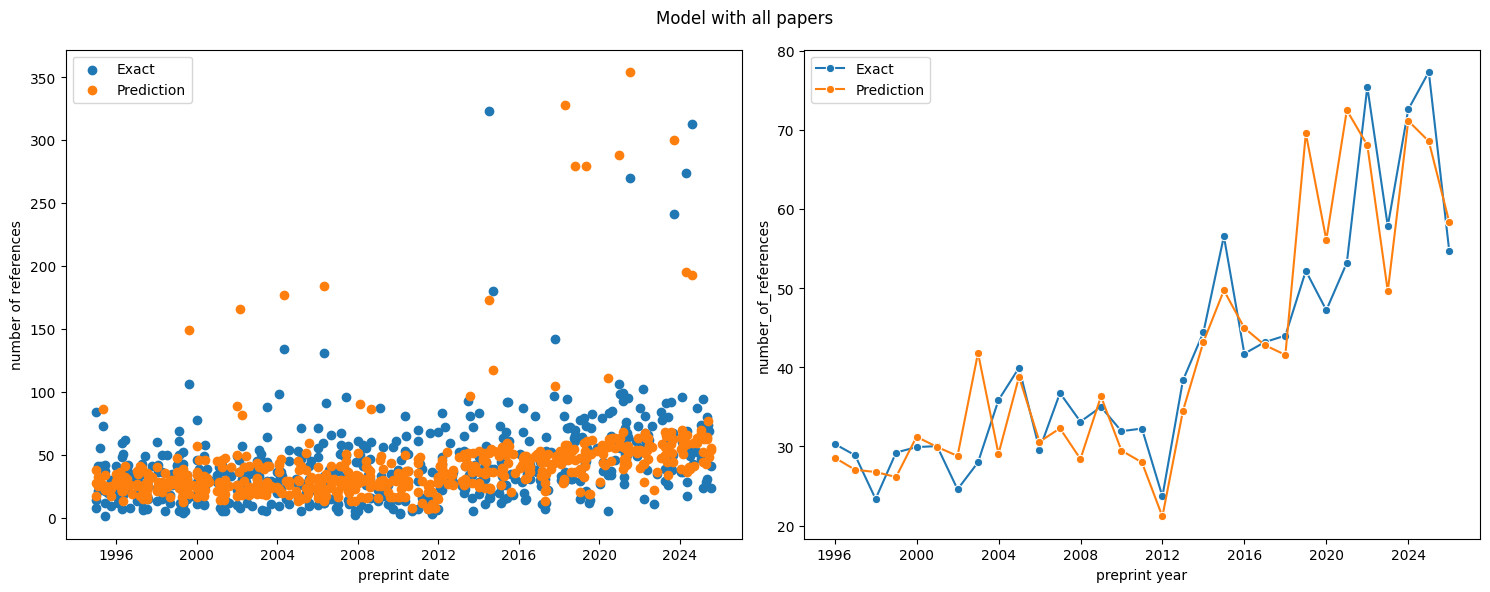

In [224]:
y_test_pred = model.predict(df_test)

base_date = pd.to_datetime('1995-01-01') 
test_date = base_date + pd.to_timedelta(df_test['preprint_date_numeric'], unit='D')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Model with all papers")#, y=0.92)

axes[0].scatter(test_date, y_test, label='Exact')
axes[0].scatter(test_date, y_test_pred, label='Prediction')
axes[0].set_xlabel('preprint date')
axes[0].set_ylabel('number of references')
axes[0].legend(loc='best')

sns.lineplot(yearly_avg_test, marker='o', label='Exact', ax=axes[1])
sns.lineplot(yearly_avg_pred, marker='o', label='Prediction', ax=axes[1])
axes[1].set_xlabel('preprint year')
# axes[1].set_ylabel('number of references')
axes[1].legend(loc='best')

plt.tight_layout()
plt.savefig("../images/img_all.png")

plt.show()

## Only considering articles

In [185]:
with open("../bin/model_article.pkl", "rb") as file:
    model_article = pickle.load(file)

In [186]:
df_test_article = df_test[df_test['document_type_article']==1.0]

y_test_article = df.loc[df_test_article.index]['number_of_references'].to_numpy()

y_test_article_pred = model.predict(df_test_article)
y_test_article2_pred = model_article.predict(df_test_article)

In [163]:
mean_squared_error(y_test_article, y_test_article_pred), mean_squared_error(y_test_article, y_test_article2_pred)

(641.10595703125, 291.2642513187112)

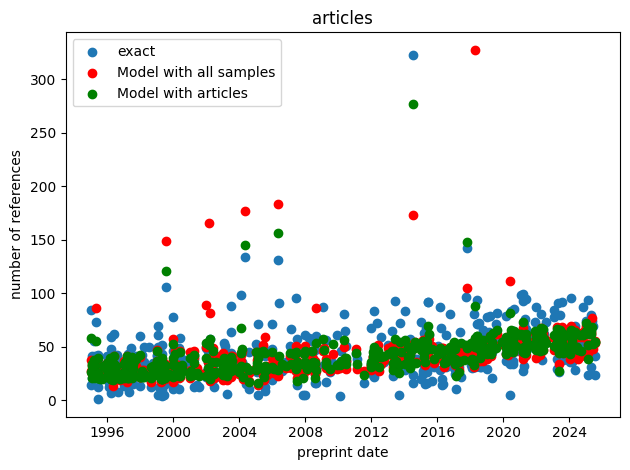

In [207]:
import matplotlib.pyplot as plt

base_date = pd.to_datetime('1995-01-01') 

test_date = base_date + pd.to_timedelta(df_test_article['preprint_date_numeric'], unit='D')

plt.title("articles")
plt.scatter(test_date, y_test_article, label='exact')
plt.scatter(test_date, y_test_article_pred, label='Model with all samples', color='red')
plt.scatter(test_date, y_test_article2_pred, label='Model with articles', color='green')
plt.xlabel('preprint date')
plt.ylabel('number of references')
plt.tight_layout()
plt.legend()

plt.show()

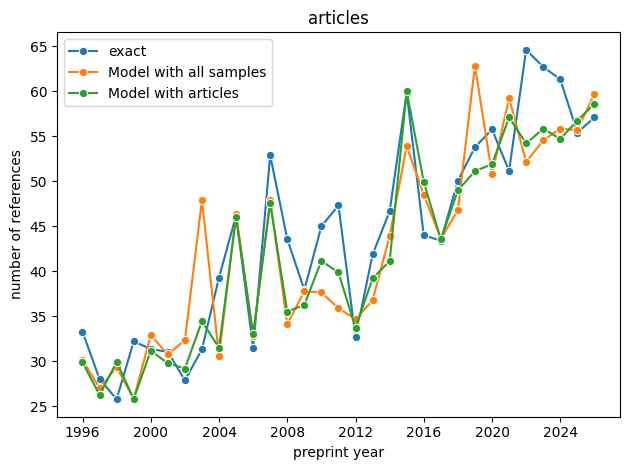

In [208]:
dfa1 = pd.DataFrame({'preprint_date': test_date, 'number_of_references':y_test_article}).set_index('preprint_date')
dfa2 = pd.DataFrame({'preprint_date': test_date, 'number_of_references':y_test_article_pred}).set_index('preprint_date')
dfa3 = pd.DataFrame({'preprint_date': test_date, 'number_of_references':y_test_article2_pred}).set_index('preprint_date')


yearly_avg_test = dfa1['number_of_references'].resample('YE').mean()
yearly_avg_pred = dfa2['number_of_references'].resample('YE').mean()
yearly_avg_pred2= dfa3['number_of_references'].resample('YE').mean()

plt.title('articles')
sns.lineplot(yearly_avg_test, marker='o', label='exact')
sns.lineplot(yearly_avg_pred, marker='o', label='Model with all samples')
sns.lineplot(yearly_avg_pred2, marker='o', label='Model with articles')
plt.xlabel('preprint year')
plt.ylabel('number of references')
plt.tight_layout()
plt.show()


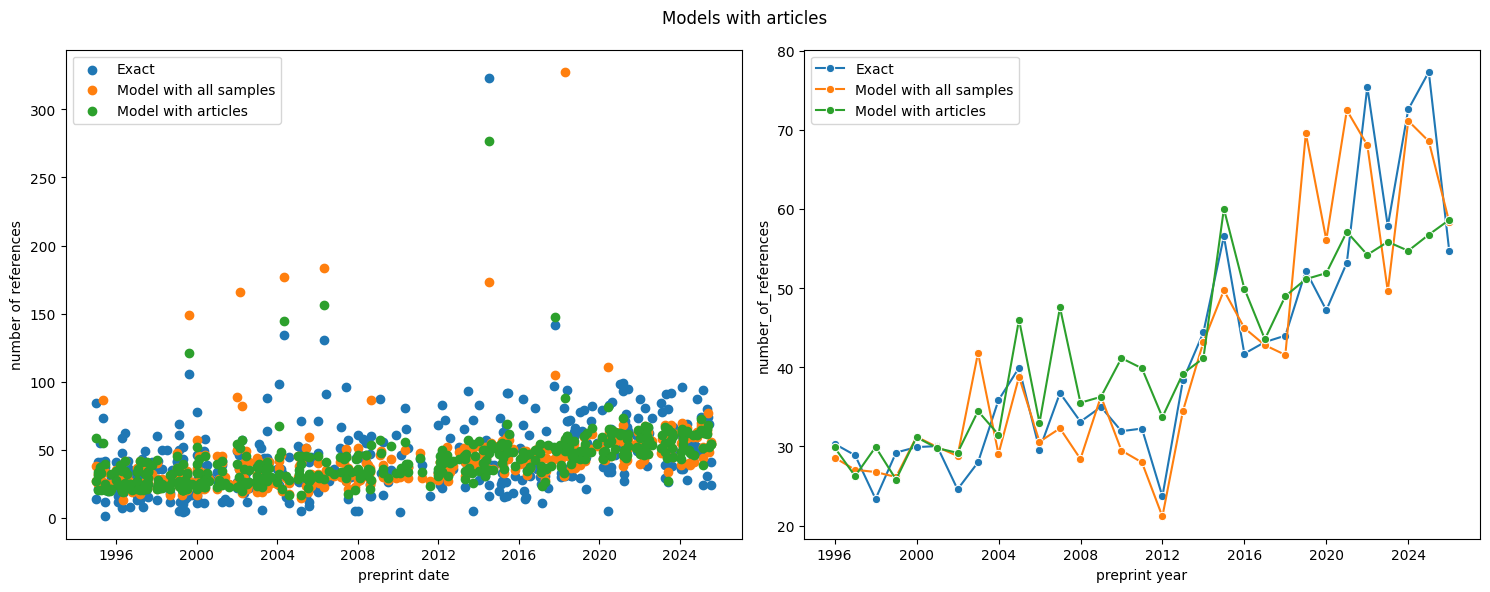

In [223]:
base_date = pd.to_datetime('1995-01-01') 
test_date = base_date + pd.to_timedelta(df_test_article['preprint_date_numeric'], unit='D')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Models with articles")#, y=0.92)

axes[0].scatter(test_date, y_test_article, label='Exact')
axes[0].scatter(test_date, y_test_article_pred, label='Model with all samples')
axes[0].scatter(test_date, y_test_article2_pred, label='Model with articles')
axes[0].set_xlabel('preprint date')
axes[0].set_ylabel('number of references')
axes[0].legend(loc='best')

sns.lineplot(yearly_avg_test, marker='o', label='Exact', ax=axes[1])
sns.lineplot(yearly_avg_pred, marker='o', label='Model with all samples', ax=axes[1])
sns.lineplot(yearly_avg_pred2, marker='o', label='Model with articles', ax=axes[1])
axes[1].set_xlabel('preprint year')
# axes[1].set_ylabel('number of references')
axes[1].legend(loc='best')

plt.tight_layout()
plt.savefig("../images/img_article.png")

plt.show()